## Code for hubmap tri integration -- small bowell part:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc

import sys
sys.path.append("../../MaxFuse_devo/09302022V/")
import match
import metrics
from scipy.io import mmread
import os
import utils, metrics

# hamrony and related 
import harmonypy as hm
from scipy.sparse.linalg import svds

## read in ATAC data (gene activity score and LSI) --SB

In [2]:
prefix = '/hubmap_fin/data/'

# read in gene activity
atacactivity = mmread(prefix + "hub_sub_genescore.txt").tocsr()

gas_names = pd.read_csv(
    prefix + 'hub_sub_genescore_names.csv'
)['names'].to_numpy()

atac_meta = pd.read_csv(prefix + "hub_sub_genescore_meta.csv")
np.unique(atac_meta['cluster.info'])

array(['B Cells', 'CD4+ T cell', 'CD8+ T cell', 'Endothelial',
       'Enteroendocrine', 'Goblet', 'Mono_Macrophages', 'Plasma',
       'Smooth muscle', 'Stroma'], dtype=object)

In [3]:
# read in peak lsi data (note this LSI is harmony corrected by Archr)

peak_lsi = pd.read_csv(prefix + 'hub_sub_lsi100_harmony.csv') # 100 components
peak_lsi = peak_lsi.drop(['LSI1'], axis=1)
peak_lsi_use = peak_lsi[(atac_meta['tissue'] == "sb").values]

In [4]:
# select small bowell cells
atacactivity_use = pd.DataFrame(atacactivity.todense())[(atac_meta['tissue'] == "sb").values]

atac_meta['cluster.info'] = atac_meta['cluster.info'].str.replace('CD4\+ T cell','T cells')
atac_meta['cluster.info'] = atac_meta['cluster.info'].str.replace('CD8\+ T cell','T cells')
labels_atac_use = atac_meta[(atac_meta['tissue'] == "sb").values]


print((atacactivity_use.shape, peak_lsi_use.shape))

((14592, 24919), (14592, 99))


/tmp/ipykernel_13460/3059297753.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  atac_meta['cluster.info'] = atac_meta['cluster.info'].str.replace('CD4\+ T cell','T cells')
/tmp/ipykernel_13460/3059297753.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  atac_meta['cluster.info'] = atac_meta['cluster.info'].str.replace('CD8\+ T cell','T cells')


In [6]:
# atac labels
atac_labels = labels_atac_use['cluster.info'].to_numpy()
atac_seurat_labels = labels_atac_use['seurat.label'].to_numpy()

In [7]:
# gene score anndata
activity_adata = ad.AnnData(atacactivity_use, dtype=np.float32)
activity_adata.var_names = gas_names

/home/bkzhu/python/miniconda3/envs/super_mario_testing/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
# peak lsi anndata
peak_adata = ad.AnnData(peak_lsi_use, dtype=np.float32)

In [9]:
## pre-processing

# gene score process consistant with the rna process
sc.pp.normalize_total(activity_adata)
sc.pp.log1p(activity_adata)

activity_adata_active = activity_adata.copy()
sc.pp.highly_variable_genes(activity_adata_active, n_top_genes=10000)
activity_adata_active = activity_adata_active[:, activity_adata_active.var.highly_variable]
sc.pp.scale(activity_adata_active)

/home/bkzhu/python/miniconda3/envs/super_mario_testing/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
## this code specific to hubmap case:
## harmony batch correct gene activity scores, based on patient label

batch = labels_atac_use['sample'].copy()
tt = labels_atac_use['sample'].shape[0]

##### per patient
for i in range(tt):
    temp = batch.iloc[i]
    batch.iloc[i] = temp[0:3]
#####

atacu, atacs, atacvT = svds(activity_adata.X, k = 100)
atacpc = atacu @ np.diag(atacs)
atac_batch = pd.DataFrame(data = batch)
atac_batch
atacho = hm.run_harmony(atacpc, atac_batch, 'sample')
print(atacho.Z_corr.T.shape)

atac_ho = atacho.Z_corr.T @ atacvT
activity_adata = ad.AnnData(
    atac_ho, dtype=np.float32
)
activity_adata  # treat this as the raw input

2023-01-13 07:56:25,710 - harmonypy - INFO - Iteration 1 of 10
2023-01-13 07:56:33,489 - harmonypy - INFO - Iteration 2 of 10
2023-01-13 07:56:36,185 - harmonypy - INFO - Iteration 3 of 10
2023-01-13 07:56:38,828 - harmonypy - INFO - Converged after 3 iterations


(14592, 100)


AnnData object with n_obs × n_vars = 14592 × 24919

In [11]:
# continue preprocessing
sc.pp.scale(activity_adata)

activity_adata.var_names = gas_names

         Falling back to preprocessing with `sc.pp.pca` and default params.


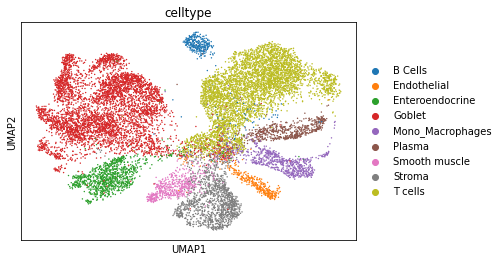

In [12]:
# quick check umap
activity_adata.obs['celltype'] = atac_labels
sc.pp.neighbors(activity_adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(activity_adata)
sc.pl.umap(activity_adata, color = ['celltype'])

In [13]:
# all feature
atac_active = activity_adata_active.X.copy()

## read in RNA -- SB

In [14]:
prefix = '/production/hubmap/match/data/'
rna = mmread(prefix + "SB_immune_rna1X.txt")
rna_stro  = mmread(prefix + "SB_stroma_rna1X.txt")
rna_epi  = mmread(prefix + "SB_epi_rna1X_v2.txt")

In [15]:
# read in rna labels
labels_rna = pd.read_csv(prefix + 'SB_immune_rna_meta1X.csv')
labels_rna_stro = pd.read_csv(prefix + 'SB_stroma_rna_meta1X.csv')
labels_rna_epi = pd.read_csv(prefix + 'SB_epi_rna_meta1X_v2.csv')
labels_rna_all1 = labels_rna.append(labels_rna_stro)
labels_rna_all = labels_rna_all1.append(labels_rna_epi)

In [16]:
# remove some cell types we won't use
drop_rna = labels_rna_all['CellType2'].isin(['NK', 'Lymphatic','Nerve'])

In [17]:
# add gene names and combine, remove cell types we dont use
rna_names = pd.read_csv(prefix + 'SB_immune_rna_names.csv')
rna = pd.DataFrame(rna.todense())
rna.columns =rna_names['names']
rna_stro = pd.DataFrame(rna_stro.todense())
rna_stro.columns =rna_names['names']
rna_epi = pd.DataFrame(rna_epi.todense())
rna_epi.columns =rna_names['names']
rna_all1 = rna.append(rna_stro)
rna_all = rna_all1.append(rna_epi)

rna_all = rna_all.loc[np.invert(drop_rna),:]
labels_rna_all = labels_rna_all.loc[np.invert(drop_rna),:]

print([rna_all.shape, labels_rna_all.shape])

[(13210, 38664), (13210, 17)]


In [18]:
# rename t cells
labels_rna_all['CellType2'] = labels_rna_all['CellType2'].str.replace('CD8\+ T cell','T cells')
labels_rna_all['CellType2'] = labels_rna_all['CellType2'].str.replace('CD4\+ T cell','T cells')
np.unique(labels_rna_all['CellType2'])

/tmp/ipykernel_13460/3033899334.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  labels_rna_all['CellType2'] = labels_rna_all['CellType2'].str.replace('CD8\+ T cell','T cells')
/tmp/ipykernel_13460/3033899334.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  labels_rna_all['CellType2'] = labels_rna_all['CellType2'].str.replace('CD4\+ T cell','T cells')


array(['B Cells', 'Endothelial', 'Enteroendocrine', 'Goblet',
       'Mono_Macrophages', 'Plasma', 'Smooth muscle', 'Stroma', 'T cells'],
      dtype=object)

In [19]:
# rna label
rna_labels = labels_rna_all['CellType2'].to_numpy()
rna_seurat_labels = labels_rna_all['seurat_clusters'].to_numpy()

In [20]:
# make adata
rna_adata = ad.AnnData(
    rna_all.to_numpy(), dtype=np.float32
)
rna_adata.var_names = rna_names['names']
rna_adata.obs_names = labels_rna_all['Unnamed: 0']

In [21]:
## with harmony correct gene counts, based on batch 'patient'

sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)

batch = labels_rna_all['orig.ident'].copy()
tt = labels_rna_all['orig.ident'].shape[0]

##### per patient
for i in range(tt):
    temp = batch.iloc[i]
    batch.iloc[i] = temp[0:4]
#####

rnau, rnas, rnavT = svds(rna_adata.X, k = 100)
rnapc = rnau @ np.diag(rnas)
rna_batch = pd.DataFrame(data = batch)
rna_batch
rnaho = hm.run_harmony(rnapc, rna_batch, 'orig.ident')
print(rnaho.Z_corr.T.shape)

2023-01-13 07:59:14,107 - harmonypy - INFO - Iteration 1 of 10
2023-01-13 07:59:20,972 - harmonypy - INFO - Iteration 2 of 10
2023-01-13 07:59:27,840 - harmonypy - INFO - Iteration 3 of 10
2023-01-13 07:59:31,839 - harmonypy - INFO - Converged after 3 iterations


(13210, 100)


In [22]:
# corrected counts
rnapc_ho = rnaho.Z_corr.T @ rnavT
rna_adata = ad.AnnData(
    rnapc_ho, dtype=np.float32
)
rna_adata

AnnData object with n_obs × n_vars = 13210 × 38664

In [23]:
# continue the process
sc.pp.highly_variable_genes(rna_adata, n_top_genes=5000)
rna_adata_active = rna_adata[:, rna_adata.var.highly_variable]
sc.pp.scale(rna_adata)
sc.pp.scale(rna_adata_active)

/home/bkzhu/python/miniconda3/envs/super_mario_testing/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


         Falling back to preprocessing with `sc.pp.pca` and default params.


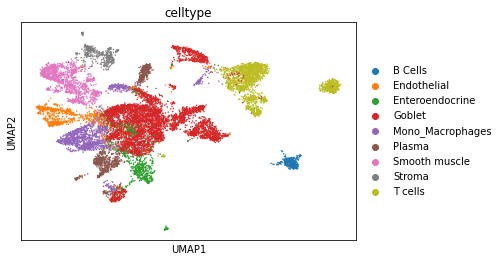

In [24]:
# quick check umap
rna_adata.obs['celltype'] = rna_labels
sc.pp.neighbors(rna_adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(rna_adata)
sc.pl.umap(rna_adata, color = ['celltype'])

umap looks correct

In [25]:
# all features
rna_active = rna_adata_active.X.copy()

## input CODEX data --SB

In [27]:
prefix = '/hubmap_fin/data/'
protein_SB = pd.read_csv(prefix + "b005_sb_cdx.csv")
protein_all = protein_SB

# remove unwanted cells
nkidx2 = protein_all.index[protein_all['cluster.term'] == 'NK'].to_list()
lymphidx2 = protein_all.index[protein_all['cluster.term'] == 'Lymphatic'].to_list()
dcidx = protein_all.index[protein_all['cluster.term'] == 'DC'].to_list()
ntpdx = protein_all.index[protein_all['cluster.term'] == 'Neutrophil'].to_list()
nrvdx = protein_all.index[protein_all['cluster.term'] == 'Nerve'].to_list()
drop_pro  = nkidx2 + lymphidx2 + dcidx + ntpdx + nrvdx

protein_all = protein_all.drop(drop_pro, axis=0)
# rename some labels
labels_protein = protein_all['cluster.term']
labels_protein = labels_protein.str.replace('CD8\+','CD8+ T cell')
labels_protein = labels_protein.str.replace('CD8\+ T cell','T cells')
labels_protein = labels_protein.str.replace('CD4\+ T cell','T cells')

/tmp/ipykernel_13460/2434463022.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  labels_protein = labels_protein.str.replace('CD8\+','CD8+ T cell')
/tmp/ipykernel_13460/2434463022.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  labels_protein = labels_protein.str.replace('CD8\+ T cell','T cells')
/tmp/ipykernel_13460/2434463022.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  labels_protein = labels_protein.str.replace('CD4\+ T cell','T cells')


In [29]:
# cdx labels

protein_labels = labels_protein.to_numpy()
protein_seurat_labels = protein_all['seurat_clusters'].to_numpy()

# codex anndata
protein_adata = ad.AnnData(
    protein_all[protein_all.columns[2:49]].to_numpy(), dtype=np.float32 # remove partial channels
    # eg olfm4 fap cd25, coiiiv, ck7
)
protein_adata.var_names = protein_all[protein_all.columns[2:49]].columns

In [30]:
protein_adata

AnnData object with n_obs × n_vars = 102696 × 47

In [31]:
# all features codex
protein_active = protein_adata.X.copy()

## MaxFuse integration part 1: RNA --> ATAC integration

In [34]:
shared_genes = np.intersect1d(rna_adata.var_names, activity_adata.var_names)
len(shared_genes)

20075

In [35]:
rna_shared = rna_adata[:,shared_genes].X.copy()
atac_shared = activity_adata[:, shared_genes].X.copy()

In [36]:
q1 = np.quantile(np.std(rna_shared, axis=0), 0.05)
q2 = np.quantile(np.std(atac_shared, axis=0), 0.05)

print([q1,q2])

[0.9999620914459229, 0.9999656677246094]


In [37]:
# remove static features
mask = ((rna_shared.std(axis=0) > q1) & (atac_shared.std(axis=0) > q2))# filter out static ones

rna_shared = rna_shared[:, mask]
atac_shared = atac_shared[:, mask]
rna_shared = ad.AnnData(rna_shared)
atac_shared = ad.AnnData(atac_shared)

In [39]:
atac_shared = atac_shared.X.copy()
rna_shared = rna_shared.X.copy()
print(atac_shared.shape, rna_shared.shape)

(14592, 16884) (13210, 16884)


### MaxFuse starts:

In [40]:
spm = match.MaxFuse(
        shared_arr1=rna_shared,
        shared_arr2=atac_shared,
        active_arr1=rna_active,
        active_arr2=atac_shared,
        method='centroid_shrinkage',
        labels1=rna_seurat_labels.astype('str'),
        labels2=atac_seurat_labels.astype('str')
    )

In [41]:
spm.split_into_batches(
    max_outward_size=5000,
    matching_ratio=4,
    metacell_size=3,
    seed=None,
    verbose=True
)

The first data is split into 1 batches, average batch size is 13210, and max batch size is 13210.
The second data is split into 1 batches, average batch size is 14592, and max batch size is 14592.
Batch to batch correspondence is:
  ['0<->0'].


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99d0bbfdf0>)

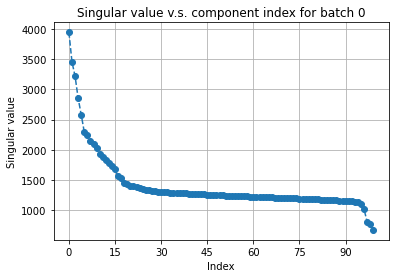

In [42]:
spm.plot_singular_values(
    target='shared_arr1',
    batch=None,
    n_components=None,
    randomized_svd=False,
    svd_runs=1
)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99d0bf2970>)

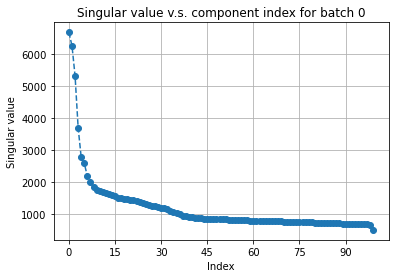

In [43]:
spm.plot_singular_values(
    target='shared_arr2',
    batch=None,
    n_components=None,
    randomized_svd=False,
    svd_runs=1
)

In [44]:
spm.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=50,
    svd_components2=50,
    resolution1=2,
    resolution2=2,
    randomized_svd=False,
    svd_runs=1,
    resolution_tol=0.1,
    leiden_runs=1,
    leiden_seed=None,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 3...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!


In [45]:
spm.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=30, svd_components2=40,
    randomized_svd=False, svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Done!


In [46]:
# test accuracy of initial matching
import utils, metrics
matching = spm._init_matching[0]
labels1 = utils.summarize_clustering(
    spm._metacell_labels1[0], rna_labels[spm._batch_to_indices1[0]]
)
labels2 = atac_labels[spm._batch_to_indices2[0]]
metrics.get_matching_acc(matching, labels1, labels2)

0.9729237770193402

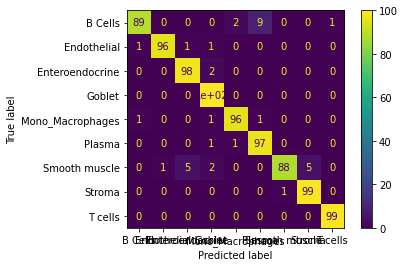

In [47]:
#plt.rcParams["figure.figsize"] = (12,8)
cm = confusion_matrix(labels1, labels2[matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
    display_labels=np.unique(labels1)
).plot()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99d0607310>)

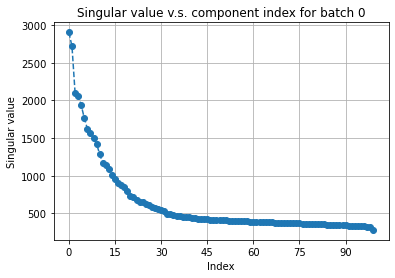

In [48]:
spm.plot_singular_values(
    target='active_arr1',
    batch=None,
    n_components=100,
    randomized_svd=False,
    svd_runs=1
)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9912a4fbe0>)

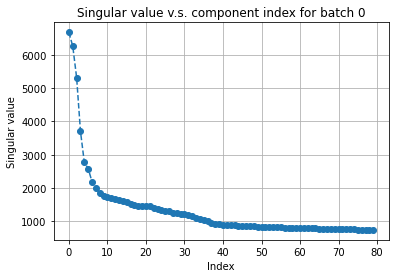

In [49]:
spm.plot_singular_values(
    target='active_arr2',
    batch=None,
    n_components=80,
    randomized_svd=False,
    svd_runs=1
)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9821c30310>)

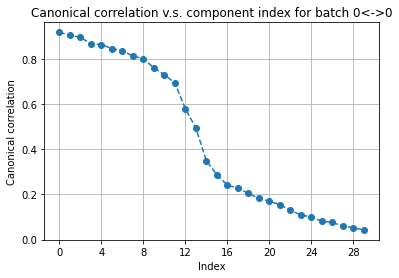

In [50]:
spm.plot_canonical_correlations(
    batch=None,
    svd_components1=40, 
    svd_components2=30,
    cca_components=30,
    filter_prop=0.,
    randomized_svd=False,
    svd_runs=1,
    cca_max_iter=2000
)

In [51]:
spm.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=30,
    cca_components=18,
    filter_prop=0.1,
    n_iters=1,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Done!


In [52]:
spm.filter_bad_matches(target='pivot', filter_prop=0., verbose=True)

Begin filtering...
Now at batch 0<->0...
4395/4395 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
13210/13210 cells in arr1 are selected as pivots.
4395/14592 cells in arr2 are selected as pivots.
Done!


In [53]:
matching = spm._refined_matching[0]
labels1 = utils.summarize_clustering(
    spm._metacell_labels1[0], rna_labels[spm._batch_to_indices1[0]]
)
# labels1 = celltype_labels_rna[mf_rna_to_atac._batch_to_indices1[0]]
labels2 = atac_labels[spm._batch_to_indices2[0]]
metrics.get_matching_acc(matching, labels1, labels2)

0.9670079635949943

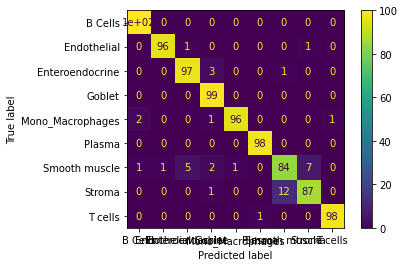

In [54]:
#plt.rcParams["figure.figsize"] = (10,6)
cm = confusion_matrix(labels1, labels2[matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
    display_labels=np.unique(labels1)
).plot()

In [55]:
spm.propagate(
    wt1=0.5,
    wt2=0.5,
    svd_components1=50, 
    svd_components2=50, 
    randomized_svd=False, 
    svd_runs=1, 
    verbose=True
)

Now at batch 0<->0...
Done!


In [56]:
spm.filter_bad_matches(
    target='propagated',
    filter_prop=0.,
    verbose=True
)

Begin filtering...
Now at batch 0<->0...
10197/10197 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [57]:
rna_to_atac_matching = spm.get_matching(order=(1, 2), target='full_data')
metrics.get_matching_acc(rna_to_atac_matching, rna_labels, atac_labels, order=(1, 2))

0.9508705526116579

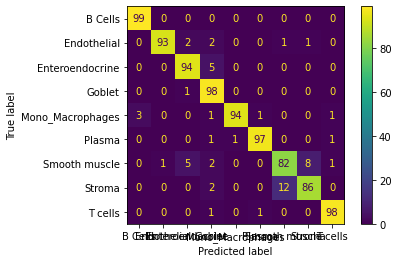

In [58]:
#plt.rcParams["figure.figsize"] = (10,6)
cm = confusion_matrix(rna_labels[rna_to_atac_matching[0]], atac_labels[rna_to_atac_matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
    display_labels=np.unique(rna_labels)
).plot()

## MaxFuse integration part 2: RNA --> CODEX integration

In [61]:
correspondence = pd.read_csv('/production/hubmap/protein_rna_name_conversionV11.csv')

In [62]:
# change names
rna_protein_correspondence = []
for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1:
        continue
    curr_rna_names = curr_rna_names.split('/')
    for r in curr_rna_names:
        if r in rna_all.columns:
            rna_protein_correspondence.append([r, curr_protein_name])
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [63]:
# get shared features
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].X.copy()

In [64]:
rna_shared = rna_all[rna_protein_correspondence[:, 0]].to_numpy()

In [65]:
rna_shared = ad.AnnData(rna_shared, dtype=np.float32)
sc.pp.normalize_total(rna_shared)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)

/home/bkzhu/python/miniconda3/envs/super_mario_testing/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [66]:
rna_shared = rna_shared.X.copy()

In [67]:
# no preprocessing for codex, expression values we got are processed version

In [68]:
mf_rna_to_protein = match.MaxFuse(
        shared_arr1=rna_shared,
        shared_arr2=utils.center_scale(protein_shared),
        active_arr1=rna_active,
        active_arr2=utils.center_scale(protein_active),
        method='centroid_shrinkage',
        labels1=rna_seurat_labels.astype(str), # if None, then use scanpy clustering pipeline
        labels2=protein_seurat_labels.astype(str)
    )

In [69]:
mf_rna_to_protein.split_into_batches(
    max_outward_size=5000,
    matching_ratio=4,
    metacell_size=3,
    seed=None,
    verbose=True
)

The first data is split into 1 batches, average batch size is 13210, and max batch size is 13210.
The second data is split into 5 batches, average batch size is 20539, and max batch size is 20540.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4'].


In [70]:
mf_rna_to_protein.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=40,
    svd_components2=40,
    resolution1=2,
    resolution2=2,
    randomized_svd=False,
    svd_runs=1,
    resolution_tol=0.1,
    leiden_runs=1,
    leiden_seed=None,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 3...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!


In [71]:
mf_rna_to_protein.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=40,
    randomized_svd=False, svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Done!


In [72]:
matching = mf_rna_to_protein._init_matching[0]
labels1 = utils.summarize_clustering(
    mf_rna_to_protein._metacell_labels1[0], rna_labels[mf_rna_to_protein._batch_to_indices1[0]]
)
# labels1 = celltype_labels_rna[mf_rna_to_atac._batch_to_indices1[0]]
labels2 = protein_labels[mf_rna_to_protein._batch_to_indices2[0]]
metrics.get_matching_acc(matching, labels1, labels2)

0.9211005002273761

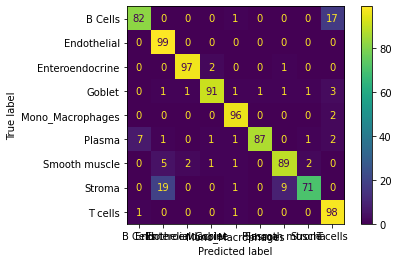

In [73]:
#plt.rcParams["figure.figsize"] = (5,5)
cm = confusion_matrix(labels1, labels2[matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
    display_labels=np.unique(labels1)
).plot()

In [180]:
mf_rna_to_protein.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=40,
    cca_components=17,
    filter_prop=0.,
    n_iters=1,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Done!


In [181]:
matching = mf_rna_to_protein._refined_matching[0]
labels1 = utils.summarize_clustering(
    mf_rna_to_protein._metacell_labels1[0], rna_labels[mf_rna_to_protein._batch_to_indices1[0]]
)
# labels1 = celltype_labels_rna[mf_rna_to_atac._batch_to_indices1[0]]
labels2 = protein_labels[mf_rna_to_protein._batch_to_indices2[0]]
metrics.get_matching_acc(matching, labels1, labels2)

0.9142792178262846

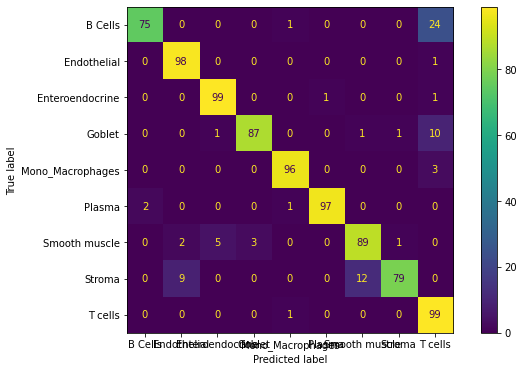

In [182]:
#plt.rcParams["figure.figsize"] = (5,5)
cm = confusion_matrix(labels1, labels2[matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
    display_labels=np.unique(labels1)
).plot()

In [183]:
mf_rna_to_protein.filter_bad_matches(target='pivot', filter_prop=0.3, verbose=True)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
15390/21990 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
11418/13210 cells in arr1 are selected as pivots.
15390/102696 cells in arr2 are selected as pivots.
Done!


In [184]:
mf_rna_to_protein.propagate(
    wt1=0.5,
    wt2=0.5,
    svd_components1=None, 
    svd_components2=None, 
    randomized_svd=False, 
    svd_runs=1, 
    verbose=True
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Done!


In [186]:
mf_rna_to_protein.filter_bad_matches(
    target='propagated',
    filter_prop=0.35,
    verbose=True
)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
61040/93906 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [187]:
rna_to_protein_matching = mf_rna_to_protein.get_matching(order=(2, 1), target='full_data')
metrics.get_matching_acc(rna_to_protein_matching, rna_labels, protein_labels, order=(2, 1))

0.929882590927108

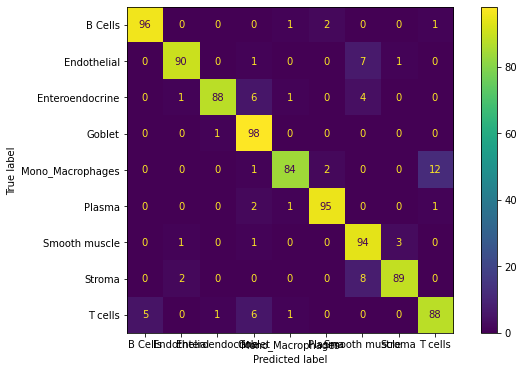

In [188]:
plt.rcParams["figure.figsize"] = (10,6)
cm = confusion_matrix(protein_labels[rna_to_protein_matching[1]], rna_labels[rna_to_protein_matching[0]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
    display_labels=np.unique(protein_labels)
).plot()

## Custome tri modality chaining code:

In [189]:
from collections import defaultdict
def get_matched_indices(pivots12, pivots23):
    # for each index in indices1, find its match in indices3
    # by using indices 2 as a transportation hub
    idx1_to_indices2 = defaultdict(set)
    for idx1, idx2 in zip(pivots12[0], pivots12[1]):
        idx1_to_indices2[idx1].add(idx2)
    
    idx2_to_indices3 = defaultdict(set)
    for idx2, idx3 in zip(pivots23[0], pivots23[1]):
        idx2_to_indices3[idx2].add(idx3)
    
    # idx1_to_indices3 = defaultdict(set)
    final_indices1, final_indices2, final_indices3 = [], [], []
    for idx1, indices2 in idx1_to_indices2.items():
        for idx2 in indices2:
            if idx2 in idx2_to_indices3:
                for idx3 in idx2_to_indices3[idx2]:
                    final_indices1.append(idx1)
                    final_indices2.append(idx2)
                    final_indices3.append(idx3)
    
    return final_indices1, final_indices2, final_indices3

In [190]:
import match_utils
rna_to_atac_full = match_utils.address_matching_redundancy(
    spm.get_matching(order=(1,2), target='full_data'), 
    order=(1,2)
)
protein_to_rna_full = match_utils.address_matching_redundancy(
    mf_rna_to_protein.get_matching(order=(2, 1), target='full_data'),
    order=(2, 1)
)

In [191]:
indices_protein, indices_rna,  indices_atac = get_matched_indices(
    # protein -> rna
    pivots12=[protein_to_rna_full[1], protein_to_rna_full[0]],
    # rna -> atac
    pivots23=[rna_to_atac_full[0], rna_to_atac_full[1]],
)

In [195]:
# 3 way correctness
np.mean([x == y == z for x, y, z in zip(
    protein_labels[indices_protein], 
    atac_labels[indices_atac],
    rna_labels[indices_rna]
)])

0.9019996446291159

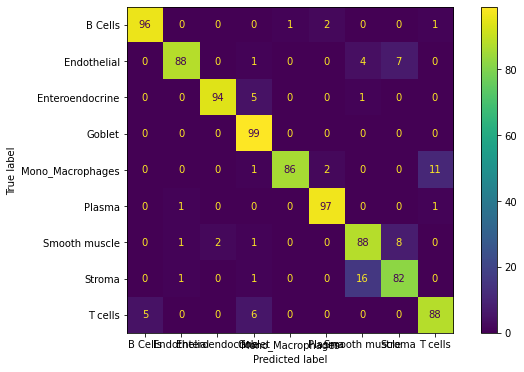

In [196]:
# check protein to atac 
plt.rcParams["figure.figsize"] = (10,6)
cm = confusion_matrix(protein_labels[indices_protein], atac_labels[indices_atac])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
    # confusion_matrix=cm, 
    display_labels=np.unique(protein_labels)
).plot()

In [197]:
dd = {'codex_indice':indices_protein, 'rna_indice':indices_rna, 'atac_indice':indices_atac}

df_full_cdx = pd.DataFrame(dd)
df_full_cdx

,codex_indice,rna_indice,atac_indice
0,20,3671,10876
1,29,3701,5861
2,53,1117,11644
3,54,3786,9508
4,64,3334,5959
...,...,...,...
73158,102690,12769,2937
73159,102692,9980,7430
73160,102693,9980,7430
73161,102694,11575,10785


In [198]:
df_full_cdx.to_csv("/hubmap_fin/output/tri_int/sb_cdx_full_indx_hh.csv", index = False)

## Since tri modality, we need to fit GCCA to get tri-embedding## Fit GCCA

In [199]:
import match_utils

In [200]:
# get pivot chaining for gcca initialization

rna_to_atac_pivots = match_utils.address_matching_redundancy(
    spm.get_matching(order=(1, 2), target='pivot'), 
    order=(1, 2)
)
rna_to_protein_pivots = match_utils.address_matching_redundancy(
    mf_rna_to_protein.get_matching(order=(1, 2), target='pivot'),
    order=(1, 2)
)

pivots_protein, pivots_rna, pivots_atac = get_matched_indices(
    # protein -> rna
    pivots12=[rna_to_protein_pivots[1], rna_to_protein_pivots[0]],
    # rna -> atac
    pivots23=[rna_to_atac_pivots[0], rna_to_atac_pivots[1]],
)

In [201]:
# check pivot three way correctness
np.mean([x == y == z for x, y, z in zip(
    protein_labels[pivots_protein], 
    atac_labels[pivots_atac],
    rna_labels[pivots_rna]
)])

0.9231914520931862

In [202]:
## helper code for gcca

from sklearn.cross_decomposition import CCA

def gcca_init(data_list, indices_list, n_components=10, max_iter=2000):
    """Initialization of GCCA.
    Parameters
    ----------
    data_list: list
        A list of data matrices, e.g., [X1, X2, X3, X4]
    indices_list: list
        A list of indices to fit GCCA on
    n_components : int, default=10
        Number of GCCA components.
    max_iter: int, default=2000
    Returns
    ----------
    embeddings_list: list
        A list of projected data.
    """
    # run CCA on the first two data matrices
    cca = CCA(n_components=n_components, max_iter=max_iter)
    cca.fit(data_list[0][indices_list[0]], data_list[1][indices_list[1]])
    # transform the first two data matrices
    embeddings_list = list(cca.transform(data_list[0], data_list[1]))
    avg_score = (embeddings_list[0][indices_list[0]] + embeddings_list[1][indices_list[1]]) / 2
    # run OLS regressions for the rest of data matrices
    for data, indices in zip(data_list[2:], indices_list[2:]):
        B = np.linalg.lstsq(data[indices], avg_score, rcond=None)[0]
        embeddings_list.append(data @ B)

    return embeddings_list

def gcca_refine(data_list, indices_list, init_embeddings_list, max_iter=500, tol=1e-3, verbose=True):
    """Refinement of GCCA.
    Parameters
    ---------
    data_list : list
        A list of data matrices.
    indices_list: list
        A list of indices to fit GCCA on
    init_embeddings_list : list
        A list of initial embeddings.
    max_iter : int, default=500
        Number of maximum iterations.
    tol : float, default=1e-3
        Algorithm terminates when the change of objective function value is <=tol.
    verbose : bool, default=True
        Print details if True.
    Returns
    ----------
    all_scores : list
        A list of projected data.
    """

    n_datasets = len(data_list)
    n_pivots = len(indices_list[0])
    n_components = init_embeddings_list[0].shape[1]

    # n_datasets * n_indices * n_components
    all_embeddings = [np.zeros_like(init_embeddings) for init_embeddings in init_embeddings_list]
    
    for ii in range(n_components):
        if verbose:
            print("Computing the {}-th canonical score...".format(ii), flush=True)
        # curr_data_list is the list of row-paired datasets to be used to fit GCCA
        if ii > 0:
            curr_data_list = []
            for idx in range(n_datasets):
                coef = np.linalg.lstsq(
                    # regress out the influence of all previous scores
                    all_embeddings[idx][indices_list[idx], :ii],
                    data_list[idx][indices_list[idx]], 
                    rcond=None
                )[0]
                curr_data_list.append(
                    data_list[idx][indices_list[idx]] - all_embeddings[idx][indices_list[idx], :ii] @ coef
                )
        else:
            curr_data_list = [data[indices] for data, indices in zip(data_list, indices_list)] 

        # preparations for entering main iteration
        curr_scores = [e[indices, ii] for e, indices in zip(init_embeddings_list, indices_list)]
        curr_embeddings = [e[:, ii] for e in init_embeddings_list]
        
        score_sum = sum(s for s in curr_scores)
        prev_obj = np.inf

        # alternating minimization
        for iter_idx in range(max_iter):
            for jj in range(n_datasets):
                y = (score_sum - curr_scores[jj]) / (n_datasets - 1)
                X = curr_data_list[jj]
                coef = np.linalg.lstsq(X, y, rcond=None)[0]
                coef = coef / np.sqrt(np.sum(coef ** 2))
                score = X @ coef
                score_sum = score_sum - curr_embeddings[jj][indices_list[jj]] + score
                # only update the locations where rows are paired
                curr_scores[jj] = score
            # check convergence
            obj = 0
            for jj in range(n_datasets - 1):
                obj += np.sqrt(np.sum((curr_scores[jj] - curr_scores[jj + 1]) ** 2))

            if verbose and iter_idx % 50 == 0:
                print("At iteration {}, the objective value is {}.".format(iter_idx, obj), flush=True)

            if abs(obj - prev_obj) < tol:
                break
            else:
                prev_obj = obj

        if verbose:
            print("Finished computing the {}-th canonical score, the objective is {}.".format(ii, obj), flush=True)

        # curr_scores are linear combinations of the residual matrices
        # convert them into linear combinations of the original data matrices
        for jj in range(n_datasets):
            coef = np.linalg.lstsq(data_list[jj][indices_list[jj]], curr_scores[jj], rcond=None)[0]
            all_embeddings[jj][:, ii] = data_list[jj] @ coef

    return all_embeddings

import umap
import seaborn as sns
def fit_umap(arr):
    u = umap.UMAP(random_state = 42).fit_transform(
        arr
    )
    return u

#### gcca run on active arrays for three modality

#### protein would be normal, rna on variable genes, atac on LSI embedding

In [203]:
# svd on active genes
rna_active_svd = utils.svd_embedding(rna_active, 50)
rna_active_svd = utils.center_scale(rna_active_svd)
# svd on active genes (atac)
atac_active_svd = utils.svd_embedding(atac_active, 50)
atac_active_svd = utils.center_scale(atac_active_svd)
# indices_protein
protein_active_svd = utils.svd_embedding(protein_active, None) # only the codex cell that has bimodality matches
protein_active_svd = utils.center_scale(protein_active_svd)

In [205]:
# initialize
init_embeddings = gcca_init(
    data_list=[rna_active_svd, atac_active_svd, protein_active_svd],
    indices_list=[pivots_rna, pivots_atac, pivots_protein],
    n_components=15 
)

In [206]:
# can check umap of inital embedding if we want
scaled_init_embeddings = [utils.center_scale(embeddings) for embeddings in init_embeddings]
init_umap = fit_umap(np.concatenate(init_embeddings, axis=0))
scaled_init_umap = fit_umap(np.concatenate(scaled_init_embeddings, axis=0))

In [207]:
# refine gcca embedding
final_embeddings = gcca_refine(
    data_list=[rna_active_svd, atac_active_svd, protein_active_svd],
    indices_list=[pivots_rna, pivots_atac, pivots_protein], 
    init_embeddings_list=scaled_init_embeddings, 
    max_iter=2000, tol=1e-3, verbose=True
)

Computing the 0-th canonical score...
At iteration 0, the objective value is 141.84604761342138.
At iteration 50, the objective value is 135.0651741210056.
Finished computing the 0-th canonical score, the objective is 135.0650585247884.
Computing the 1-th canonical score...
At iteration 0, the objective value is 182.589869738277.
At iteration 50, the objective value is 181.5879141860032.
At iteration 100, the objective value is 183.82127780122522.
At iteration 150, the objective value is 184.43331516405604.
At iteration 200, the objective value is 184.69796489582995.
At iteration 250, the objective value is 184.83799799108562.
At iteration 300, the objective value is 184.92108396857108.
Finished computing the 1-th canonical score, the objective is 184.95752050530308.
Computing the 2-th canonical score...
At iteration 0, the objective value is 195.78795329032488.
At iteration 50, the objective value is 191.2371231586356.
At iteration 100, the objective value is 192.23082745541836.
At it

At iteration 100, the objective value is 219.75442231475157.
At iteration 150, the objective value is 219.91466150824374.
At iteration 200, the objective value is 220.0110681267756.
At iteration 250, the objective value is 220.07662227517565.
Finished computing the 12-th canonical score, the objective is 220.0955031786395.
Computing the 13-th canonical score...
At iteration 0, the objective value is 238.13758066232717.
At iteration 50, the objective value is 234.8605393149516.
At iteration 100, the objective value is 235.15568810166226.
At iteration 150, the objective value is 235.2593072911935.
Finished computing the 13-th canonical score, the objective is 235.2958239545167.
Computing the 14-th canonical score...
At iteration 0, the objective value is 232.39940507290072.
At iteration 50, the objective value is 232.24495117359882.
At iteration 100, the objective value is 230.8100756670884.
At iteration 150, the objective value is 230.34036344470178.
At iteration 200, the objective valu

In [208]:
scaled_final_embeddings = [utils.center_scale(embeddings) for embeddings in final_embeddings]
scaled_final_umap = fit_umap(np.concatenate(scaled_final_embeddings, axis=0))

## Save out cca score for downstream analaysis

In [220]:
allcca = np.concatenate(scaled_final_embeddings, axis=0)
allcca_df = pd.DataFrame(allcca)
allcca_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1.261899,-1.652483,1.760268,0.834581,-0.705081,-0.855185,-0.067037,-0.090527,0.058626,-0.221506,0.285355,-1.022743,0.313978,-0.896341,-0.047348
1,-1.433098,-1.374156,2.538483,1.315104,-0.125159,-0.510845,0.186381,-0.354913,0.523962,0.002564,2.237167,-0.002110,0.111092,-1.890208,-0.458210
2,-1.402541,-0.921599,-0.665986,-0.727563,-0.052874,-0.530646,0.466887,-0.617115,0.541168,-0.443538,0.569287,-0.569901,-1.139140,0.490433,0.501814
3,-1.520215,-1.305838,-0.252454,-1.254920,0.316451,-0.193934,-0.237352,1.384535,0.079936,0.828432,0.720936,0.344797,-0.149053,0.198726,1.388270
4,-1.062691,-1.071104,-0.030149,-0.883996,0.246940,-0.144256,0.847500,0.496267,0.353329,0.223308,0.832470,-1.435075,-0.732628,0.652897,0.169081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130493,0.501988,0.877956,0.231420,0.142709,-0.577106,-0.049842,0.470336,-0.325765,-1.807569,0.023590,-1.625063,0.018972,-1.852113,0.912092,-0.977211
130494,0.890802,2.069823,-0.534749,0.300682,-1.570494,0.625104,0.274824,-0.751708,-4.651197,-0.877064,-4.471241,-1.766912,-8.669038,4.505647,-4.451165
130495,0.755223,1.580526,-0.185589,0.349750,-1.049348,0.170333,-0.329556,-0.529199,-3.784782,-0.484131,-3.057040,-0.906585,-4.609503,2.192158,-2.781998
130496,0.819042,1.751320,-0.289531,0.247969,-1.098067,0.451288,0.391816,-0.586742,-3.400737,-0.558577,-3.782531,-1.374642,-6.292202,3.453590,-3.405178


In [221]:
allcca_df.to_csv("/hubmap_fin/output/tri_int/sb_cdx_gcca_hh_preUmap.csv", index = False)